# Lighting Variation Impact on Urban Garbage Detection - GIGO Dataset Analysis

This notebook analyzes the GIGO dataset to investigate how lighting conditions affect garbage recognition performance in street-level imagery.

## Research Questions
**RQ:** How do lighting conditions, as they vary across different times of day, affect class-specific garbage recognition performance in street-level imagery, and to what extent can explicitly modeling lighting information improve robustness under challenging conditions?

## Hypotheses
- **H1:** Poor lighting conditions lead to lower recognition performance for visually small or fine-grained garbage categories (e.g., litter) compared to larger object categories
- **H2:** Categories involving large objects (e.g., bulky waste) are less sensitive to variations in lighting conditions  
- **H3:** A CNN with lighting embeddings improves classification performance under challenging lighting conditions compared to image-only baseline

## Dataset Overview
The GIGO dataset contains:
- **25,000 street-view images** from Amsterdam
- **Metadata:** timestamps, GPS coordinates, privacy blur information
- **Annotations:** Multi-label classification for garbage categories
- **Categories:** garbage, bulky waste, garbage bag, cardboard, litter

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the GIGO dataset
data_path = "/Users/daniel/Documents/Applied/GIGO/"

# Load annotations and metadata
annotations = pd.read_csv(data_path + "annotations.csv")
metadata = pd.read_csv(data_path + "metadata.csv")

print("Dataset loaded successfully!")
print(f"Annotations shape: {annotations.shape}")
print(f"Metadata shape: {metadata.shape}")

# Display first few rows of each dataset
print("\n=== Annotations Sample ===")
print(annotations.head())
print("\n=== Metadata Sample ===")
print(metadata.head())

Dataset loaded successfully!
Annotations shape: (24999, 9)
Metadata shape: (25000, 7)

=== Annotations Sample ===
  new_filename  train  test  garbage  bulkywaste  garbagebag  cardboard  \
0    10905.jpg      1     0        1           1           1          1   
1     1544.jpg      1     0        1           1           1          1   
2     5959.jpg      1     0        0           0           0          0   
3     4695.jpg      1     0        1           1           1          1   
4    15980.jpg      1     0        0           0           0          0   

   litter                                             labels  
0       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
1       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
2       0                                                 []  
3       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
4       0                                                 []  

=== Metadata Sample ===
    filename privacy_blurs      

## Step 1: Load Metadata and Images

Loading metadata.csv and preparing to process images from blurred_images_all/ directory.

In [3]:
# Load metadata and set up image processing
import cv2
import os
from PIL import Image
import ast

# Load metadata.csv
metadata = pd.read_csv(data_path + "metadata.csv")
print(f"Loaded metadata for {len(metadata)} images")

# Set up image directory path
images_dir = data_path + "blurred_images_all/"
print(f"Image directory: {images_dir}")
print(f"Number of image files: {len(os.listdir(images_dir))}")

Loaded metadata for 25000 images
Image directory: /Users/daniel/Documents/Applied/GIGO/blurred_images_all/
Number of image files: 25000


## Step 2: Compute ROI-Based Mean Brightness

Computing mean brightness from top 85% ROI while excluding privacy blur regions.

In [25]:
def compute_brightness_with_mask(image_path, privacy_blurs_str):
    """
    Compute mean brightness from top 85% ROI, excluding privacy blur regions.
    Returns: (mean_brightness_roi, blur_coverage_roi)
    """
    # Load image and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    
    # Crop to ROI (top 85% of image to remove dashboard artifacts)
    roi_height = int(height * 0.85)
    roi = gray[:roi_height, :]
    
    # Create mask for privacy blurs within ROI
    mask = np.ones((roi_height, width), dtype=np.uint8)
    blur_area = 0
    
    # Parse privacy blurs
    if privacy_blurs_str != '[]' and privacy_blurs_str != '':
        try:
            # Handle the privacy_blurs format
            blur_lines = ast.literal_eval(privacy_blurs_str)
            if blur_lines:
                for blur_line in blur_lines:
                    # Parse YOLO format: class x_center y_center width height
                    parts = blur_line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, box_width, box_height = map(float, parts)
                        
                        # Convert from normalized to pixel coordinates (based on full image)
                        x_center *= width
                        y_center *= height
                        box_width *= width
                        box_height *= height
                        
                        # Calculate box corners
                        x1 = max(0, int(x_center - box_width/2))
                        y1 = max(0, int(y_center - box_height/2))
                        x2 = min(width, int(x_center + box_width/2))
                        y2 = min(roi_height, int(y_center + box_height/2))  # Clip to ROI
                        
                        # Only apply mask if blur intersects with ROI
                        if y1 < roi_height and y2 > 0:
                            y1 = max(0, y1)
                            y2 = min(roi_height, y2)
                            # Set mask to 0 for blur region
                            mask[y1:y2, x1:x2] = 0
                            blur_area += (x2-x1) * (y2-y1)
        except:
            pass  # If parsing fails, use full ROI
    
    # Calculate blur coverage relative to ROI area
    roi_area = roi_height * width
    blur_coverage_roi = blur_area / roi_area if roi_area > 0 else 0
    
    # Compute mean brightness only on non-masked ROI pixels
    masked_pixels = roi[mask == 1]
    mean_brightness_roi = np.mean(masked_pixels) if len(masked_pixels) > 0 else np.mean(roi)
    
    return mean_brightness_roi, blur_coverage_roi

print("Brightness computation function defined")

Brightness computation function defined


In [26]:
# Check if metadata with lighting already exists
lighting_file = data_path + "metadata_with_lighting.csv"

if os.path.exists(lighting_file):
    print("Loading existing metadata with lighting information...")
    metadata_with_lighting = pd.read_csv(lighting_file)
    print("Existing metadata loaded successfully!")
else:
    # Process all images to compute brightness values
    print("Processing images for brightness computation...")
    
    brightness_values = []
    blur_coverages = []
    
    total_images = len(metadata)
    
    for idx in range(total_images):
        row = metadata.iloc[idx]
        image_path = os.path.join(images_dir, row['filename'])
        
        if os.path.exists(image_path):
            brightness, blur_coverage = compute_brightness_with_mask(
                image_path, str(row['privacy_blurs'])
            )
            brightness_values.append(brightness)
            blur_coverages.append(blur_coverage)
        else:
            brightness_values.append(None)
            blur_coverages.append(None)
    
    # Add computed values to metadata
    metadata_with_lighting = metadata.copy()
    metadata_with_lighting['mean_brightness_roi'] = brightness_values
    metadata_with_lighting['blur_coverage_roi'] = blur_coverages
    
    print("Processing complete")

print(f"Total images processed: {len(metadata_with_lighting)}")
print(f"Images with valid brightness: {metadata_with_lighting['mean_brightness_roi'].notna().sum()}")
print(f"Images with failed processing: {metadata_with_lighting['mean_brightness_roi'].isna().sum()}")

Processing images for brightness computation...
Processing complete
Total images processed: 25000
Images with valid brightness: 25000
Images with failed processing: 0
Processing complete
Total images processed: 25000
Images with valid brightness: 25000
Images with failed processing: 0


## Step 3: Bin Lighting Conditions

Creating quantile-based lighting categories using mean brightness from ROI.

In [27]:
# Compute quantile-based lighting bins for all images with valid brightness
all_brightness = metadata_with_lighting['mean_brightness_roi'].dropna()

# Calculate quantiles
q33 = all_brightness.quantile(0.33)
q67 = all_brightness.quantile(0.67)

print(f"Mean brightness ROI quantiles:")
print(f"33rd percentile: {q33:.2f}")
print(f"67th percentile: {q67:.2f}")

# Create lighting level categories (no validity filtering)
def categorize_lighting(brightness):
    if pd.isna(brightness):
        return None
    elif brightness <= q33:
        return 'low_light'
    elif brightness <= q67:
        return 'medium_light'
    else:
        return 'high_light'

metadata_with_lighting['lighting_level'] = metadata_with_lighting['mean_brightness_roi'].apply(categorize_lighting)

# Convert to categorical
metadata_with_lighting['lighting_level'] = pd.Categorical(
    metadata_with_lighting['lighting_level'], 
    categories=['low_light', 'medium_light', 'high_light'],
    ordered=True
)

# Display lighting distribution
lighting_counts = metadata_with_lighting['lighting_level'].value_counts()
print(f"\nLighting level distribution:")
print(lighting_counts)
print(f"Images with failed processing: {metadata_with_lighting['lighting_level'].isna().sum()}")

Mean brightness ROI quantiles:
33rd percentile: 115.07
67th percentile: 130.45

Lighting level distribution:
lighting_level
medium_light    8500
low_light       8250
high_light      8250
Name: count, dtype: int64
Images with failed processing: 0


## Step 4: Save Metadata with Lighting

Saving the enriched metadata with brightness and lighting information.

In [28]:
# Save enriched metadata (do NOT overwrite original)
output_path = data_path + "metadata_with_lighting.csv"
metadata_with_lighting.to_csv(output_path, index=False)

print(f"Metadata with lighting saved to: {output_path}")
print(f"Metadata shape: {metadata_with_lighting.shape}")
print(f"New columns added: {set(metadata_with_lighting.columns) - set(metadata.columns)}")

Metadata with lighting saved to: /Users/daniel/Documents/Applied/GIGO/metadata_with_lighting.csv
Metadata shape: (25000, 10)
New columns added: {'mean_brightness_roi', 'blur_coverage_roi', 'lighting_level'}


## Step 5: Basic Exploratory Data Analysis (EDA)

Creating minimal EDA outputs for lighting analysis.

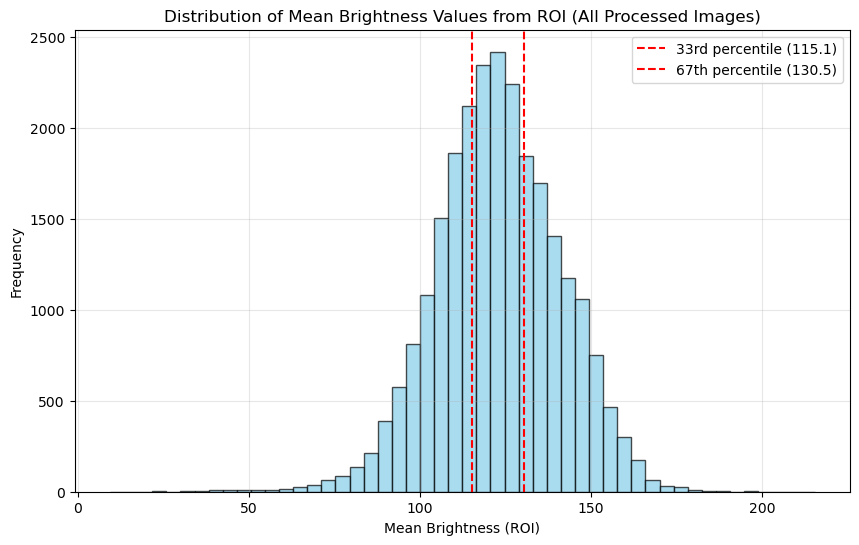

In [29]:
# Histogram of mean_brightness_roi (all processed images)
processed_data = metadata_with_lighting[metadata_with_lighting['mean_brightness_roi'].notna()]

plt.figure(figsize=(10, 6))
plt.hist(processed_data['mean_brightness_roi'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(q33, color='red', linestyle='--', label=f'33rd percentile ({q33:.1f})')
plt.axvline(q67, color='red', linestyle='--', label=f'67th percentile ({q67:.1f})')
plt.xlabel('Mean Brightness (ROI)')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Brightness Values from ROI (All Processed Images)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Count of images per lighting level:
lighting_level
medium_light    8500
low_light       8250
high_light      8250
Name: count, dtype: int64


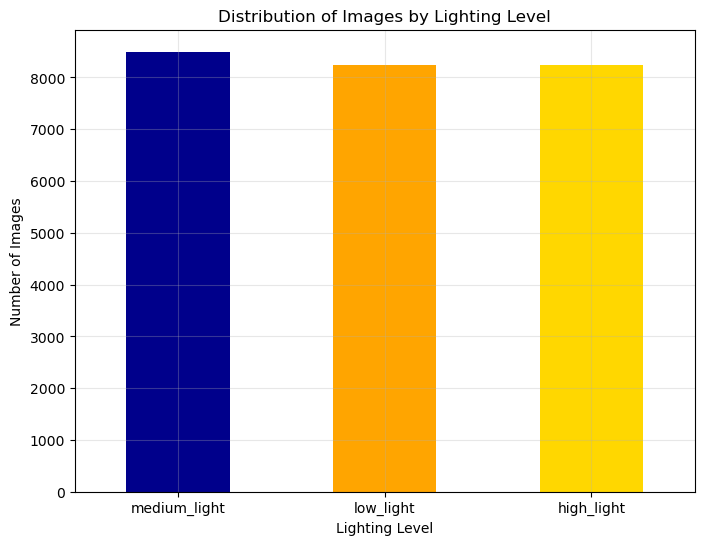

In [30]:
# Count of images per lighting_level
lighting_counts = metadata_with_lighting['lighting_level'].value_counts()
print("Count of images per lighting level:")
print(lighting_counts)

# Create bar plot
plt.figure(figsize=(8, 6))
lighting_counts.plot(kind='bar', color=['darkblue', 'orange', 'gold'])
plt.title('Distribution of Images by Lighting Level')
plt.xlabel('Lighting Level')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

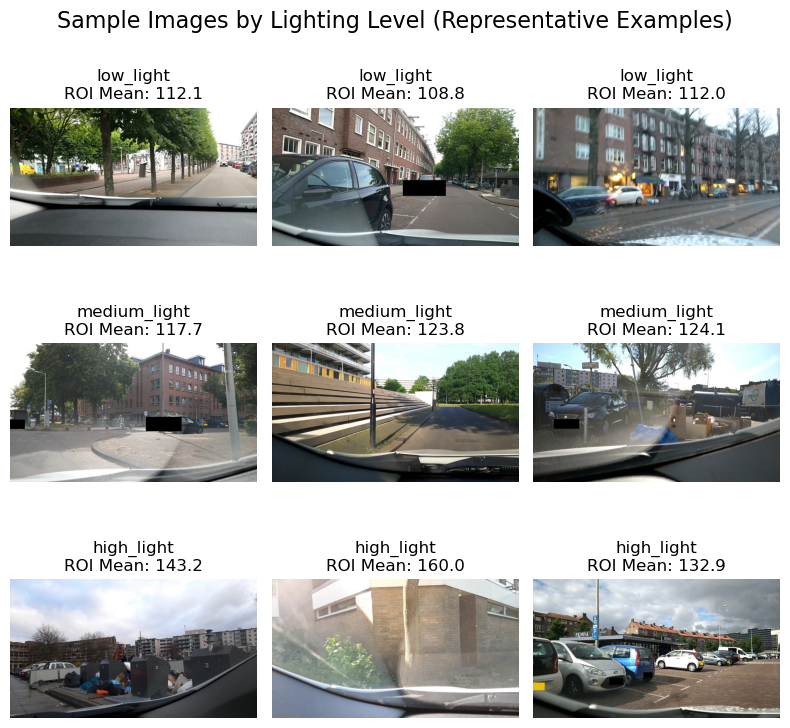

In [33]:
# Display 3 random example images per lighting level (processed images only, excluding extreme outliers)
np.random.seed(42)  # For reproducible results

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Sample Images by Lighting Level (Representative Examples)', fontsize=16)

lighting_levels = ['low_light', 'medium_light', 'high_light']

for i, level in enumerate(lighting_levels):
    # Get images for this lighting level with valid brightness
    level_images = metadata_with_lighting[
        (metadata_with_lighting['lighting_level'] == level) & 
        (metadata_with_lighting['mean_brightness_roi'].notna())
    ]
    
    # Filter out extreme outliers (bottom 5% and top 5% within each category)
    brightness_col = level_images['mean_brightness_roi']
    lower_bound = brightness_col.quantile(0.05)
    upper_bound = brightness_col.quantile(0.95)
    
    filtered_images = level_images[
        (brightness_col >= lower_bound) & 
        (brightness_col <= upper_bound)
    ]
    
    # Sample 3 random images from filtered set
    sampled = filtered_images.sample(n=3, random_state=42)
    
    for j, (idx, row) in enumerate(sampled.iterrows()):
        image_path = os.path.join(images_dir, row['filename'])
        
        # Load and display image
        img = cv2.imread(image_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img_rgb)
            axes[i, j].set_title(f'{level}\nROI Mean: {row["mean_brightness_roi"]:.1f}')
            axes[i, j].axis('off')
        else:
            axes[i, j].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Multi-Label Garbage Classification Model

PyTorch pipeline for training a ResNet50 model on the GIGO dataset with lighting condition analysis.

In [39]:
# Load, merge minimal metadata, filter brightness outliers, split
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Load data
annotations = pd.read_csv(data_path + "annotations.csv")
df_meta = pd.read_csv(data_path + "metadata_with_lighting.csv")

# Keep only required metadata columns
df_meta = df_meta[['filename', 'lighting_level', 'mean_brightness_roi']]
df_meta = df_meta.rename(columns={"filename": "new_filename"})

# Drop old split indicator columns if present
split_cols = [col for col in annotations.columns if col.lower() in 
              ['train', 'test', 'val', 'is_train', 'is_test', 'split', 'set', 'subset']]
if split_cols:
    annotations = annotations.drop(columns=split_cols)

# Merge on new_filename
df = annotations.merge(df_meta, on='new_filename', how='inner')

# Drop rows missing required columns
label_cols = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
required_cols = ['new_filename', 'lighting_level', 'mean_brightness_roi'] + label_cols
df = df.dropna(subset=required_cols)

# Convert label columns to numeric (in case they are strings)
for col in label_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows where labels couldn't be converted
df = df.dropna(subset=label_cols)

# Remove outliers of mean_brightness_roi within each lighting_level using IQR
def remove_outliers_iqr(group):
    
    Q1 = group['mean_brightness_roi'].quantile(0.25)
    Q3 = group['mean_brightness_roi'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['mean_brightness_roi'] >= lower_bound) & 
                 (group['mean_brightness_roi'] <= upper_bound)]

df = df.groupby('lighting_level').apply(remove_outliers_iqr).reset_index(drop=True)

# Stratified splits by lighting_level: 75% train, 5% val, 20% test
train_and_val, test = train_test_split(df, test_size=0.20, stratify=df['lighting_level'], random_state=42)
train, val = train_test_split(train_and_val, test_size=0.0625, stratify=train_and_val['lighting_level'], random_state=42)

# Save splits with only required columns
split_cols = ['new_filename', 'lighting_level'] + label_cols
train[split_cols].to_csv(data_path + "train_split.csv", index=False)
val[split_cols].to_csv(data_path + "val_split.csv", index=False)
test[split_cols].to_csv(data_path + "test_split.csv", index=False)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
print("Split distribution:")
for split_name, split_df in [("Train", train), ("Val", val), ("Test", test)]:
    print(f"{split_name}: {split_df['lighting_level'].value_counts().to_dict()}")

Train: 18457, Val: 1231, Test: 4922
Split distribution:
Train: {'medium_light': 6374, 'high_light': 6112, 'low_light': 5971}
Val: {'medium_light': 425, 'high_light': 408, 'low_light': 398}
Test: {'medium_light': 1700, 'high_light': 1630, 'low_light': 1592}


In [42]:
# CELL 2: Minimal Dataset + DataLoaders
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class GIGODataset(Dataset):
    def __init__(self, dataframe, image_root, transform=None):
        # Drop rows where image file doesn't exist
        valid_files = []
        for _, row in dataframe.iterrows():
            if os.path.exists(os.path.join(image_root, row['new_filename'])):
                valid_files.append(row)
        
        self.df = pd.DataFrame(valid_files).reset_index(drop=True)
        self.image_root = image_root
        self.transform = transform
        self.label_cols = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.image_root, row['new_filename'])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Labels as float32 - ensure numeric conversion
        label_values = []
        for col in self.label_cols:
            val = row[col]
            if isinstance(val, str):
                val = float(val)
            label_values.append(val)
        labels = torch.tensor(label_values, dtype=torch.float32)
        
        return image, labels, row['lighting_level']

# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load split data
train_df = pd.read_csv(data_path + "train_split.csv")
val_df = pd.read_csv(data_path + "val_split.csv")
test_df = pd.read_csv(data_path + "test_split.csv")

# Create datasets
train_dataset = GIGODataset(train_df, images_dir, train_transform)
val_dataset = GIGODataset(val_df, images_dir, test_transform)
test_dataset = GIGODataset(test_df, images_dir, test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset sizes - Train: 18457, Val: 1231, Test: 4922


In [ ]:
# CELL 3: ResNet50 multi-label training (MPS only)
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score

# Force Apple GPU
assert torch.backends.mps.is_available(), 
device = torch.device("mps")

# Model: ResNet50 with 5 output classes
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Val Macro-F1: {val_f1:.4f}")

Epoch 1: Train Loss: 0.3543, Val Macro-F1: 0.5171
Epoch 2: Train Loss: 0.3258, Val Macro-F1: 0.5379
Epoch 2: Train Loss: 0.3258, Val Macro-F1: 0.5379


KeyboardInterrupt: 

In [ ]:
# CELL 4: Test evaluation
# Overall test evaluation
model.eval()
test_preds, test_labels, test_lighting = [], [], []
with torch.no_grad():
    for images, labels, lighting in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
        test_preds.extend(preds)
        test_labels.extend(labels.cpu().numpy())
        test_lighting.extend(lighting)

# Overall metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
overall_f1 = f1_score(test_labels, test_preds, average='macro')

label_names = ['garbage', 'bulkywaste', 'garbagebag', 'cardboard', 'litter']
per_class_f1 = f1_score(test_labels, test_preds, average=None)

print("Overall Test Results:")
print(f"Macro-F1: {overall_f1:.4f}")
print("Per-class F1:")
for i, label in enumerate(label_names):
    print(f"  {label}: {per_class_f1[i]:.4f}")

# Evaluation by lighting level
print("\nTest Results by Lighting Level:")
test_df_eval = test_df.iloc[:len(test_preds)].copy()  # Match actual test size
test_df_eval['lighting_level'] = test_lighting

for lighting_level in ['low_light', 'medium_light', 'high_light']:
    mask = test_df_eval['lighting_level'] == lighting_level
    if mask.sum() > 0:
        level_preds = test_preds[mask]
        level_labels = test_labels[mask]
        level_f1 = f1_score(level_labels, level_preds, average='macro')
        print(f"{lighting_level}: Macro-F1: {level_f1:.4f} (n={mask.sum()})")